In [9]:
import pandas as pd
from nltk.tokenize import word_tokenize

#nltk.download('punkt')

# Declare the selected keyword
selected_keyword = ["well-being", "happiness", "life satisfaction", "liveability"]  # Initial value
translations = ["hyvinvointi", "vointi", "onnellisuus", "onni", "elämään tyytyväisyyttä", "elävyyttä"]
translations = translations + selected_keyword

# Load the CSV file into a DataFrame
df = pd.read_csv('data/parsed_data_sample.csv')
# Filter out only threads
threads_df = df[df['msg_type'] == 'thread_start']
print (threads_df)

# Function to check if the keyword is in the text
def contains_keyword(text):
    tokens = word_tokenize(text.lower())  # Convert text to lowercase for case-insensitive matching
    return any(translation in tokens for translation in translations)

# Filter threads containing the keyword in title or thread_text
filtered_threads = threads_df[threads_df['title'].apply(contains_keyword) | threads_df['thread_text'].apply(contains_keyword)]

# Save the filtered results to a new CSV file
filtered_threads[['title', 'thread_text', 'datetime']].to_csv('data/filtered_threads.csv', index=False)


            msg_type             datetime  \
0       thread_start  2018-01-01 00:00:00   
162     thread_start  2018-01-01 00:00:05   
466     thread_start  2018-01-01 00:01:40   
473     thread_start  2018-01-01 00:01:59   
738     thread_start  2018-01-01 00:07:08   
...              ...                  ...   
344338  thread_start  2018-01-24 14:06:46   
344343  thread_start  2018-01-24 14:07:07   
344344  thread_start  2018-01-24 14:08:01   
344345  thread_start  2018-01-24 14:08:34   
344347  thread_start  2018-01-24 14:08:51   

                                                    title  thread_id  \
0                                 Unohda en sinua koskaan   15127813   
162                     Hyvää Uutta Vuotta 2018 Kaikille!   15127814   
466                               Onnellista vuotta 2018!   15127815   
473                                    En Äänestä Larikaa   15127816   
738                                    Onko tosiaan niin,   15127818   
...                        

In [1]:
#Section 2
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Load the dataset
df = pd.read_csv('data/filtered_threads.csv')  # Replace with the path to your dataset

# Function to extract the year from the 'datetime' column
def extract_year(date_string):
    return int(date_string[:4])

# Create a dictionary to store sub-datasets for each year
yearly_datasets = {}

# Loop through the dataset and separate data for each year
for year in range(2001, 2019):
    # Filter data for the current year
    data_for_year = df[df['datetime'].apply(lambda x: extract_year(x) == year)]
    yearly_datasets[f'dat{year}'] = data_for_year

# Function to calculate vocabulary for each year
def get_vocabulary(data):
    tokens = []
    for text in data['thread_text']:
        if isinstance(text, str):  # Check if text is a valid string
            text = text.lower()  # Convert to lowercase for consistency
            tokens.extend(word_tokenize(text))
    fdist = FreqDist(tokens)
    return fdist  # Use FreqDist to get word frequencies

# Create a dictionary to store the vocabulary for each year
vocabulary_by_year = {}

# Calculate vocabulary for each year
for year, data in yearly_datasets.items():
    year_vocabulary = get_vocabulary(data)
    vocabulary_by_year[year] = year_vocabulary

# Print or manipulate the vocabulary data as needed
for year, vocab in vocabulary_by_year.items():
    print(f"Year {year}: Vocabulary Size = {len(vocab)}")

Year dat2001: Vocabulary Size = 14152
Year dat2002: Vocabulary Size = 36946
Year dat2003: Vocabulary Size = 52222
Year dat2004: Vocabulary Size = 0
Year dat2005: Vocabulary Size = 0
Year dat2006: Vocabulary Size = 0
Year dat2007: Vocabulary Size = 0
Year dat2008: Vocabulary Size = 0
Year dat2009: Vocabulary Size = 0
Year dat2010: Vocabulary Size = 0
Year dat2011: Vocabulary Size = 0
Year dat2012: Vocabulary Size = 0
Year dat2013: Vocabulary Size = 0
Year dat2014: Vocabulary Size = 0
Year dat2015: Vocabulary Size = 0
Year dat2016: Vocabulary Size = 0
Year dat2017: Vocabulary Size = 0
Year dat2018: Vocabulary Size = 0


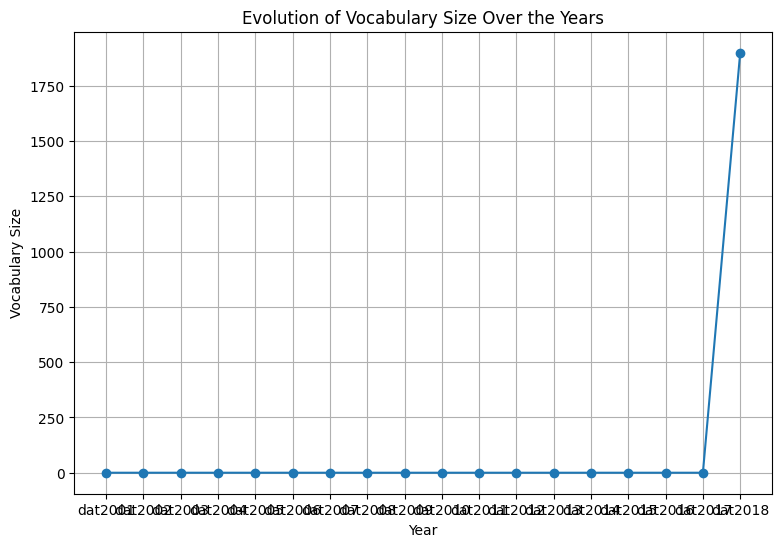

In [15]:
#Section3
import matplotlib.pyplot as plt

# Extract require data
years = list(vocabulary_by_year.keys())
vocab_sizes = [len(vocab) for vocab in vocabulary_by_year.values()]

# Create a line plot to show vocabulary evolution over the years
plt.figure(figsize=(9, 6))
plt.plot(years, vocab_sizes, marker='o', linestyle='-')
plt.title('Evolution of Vocabulary Size Over the Years')
plt.xlabel('Year')
plt.ylabel('Vocabulary Size')
plt.grid(True)
plt.show()


In [2]:
#Section 4
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

results = {}
confidence_levels = [0.8, 0.85, 0.9, 0.95]
# Loop for each year
for year, data in yearly_datasets.items():
    tokens = []
    vocab_sizes = []
    for text in data['thread_text']:
        if isinstance(text, str):
            text = text.lower()
            tokenized = word_tokenize(text)
            tokens.extend(tokenized)
            vocab_sizes.append(len(set(tokens)))

    #  a linear regression model (Heaps law) 
    x = np.arange(1, len(tokens) + 1)
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.log(x), np.log(vocab_sizes))

    # Calculate predicted vocabulary size by  linear model
    predicted_vocab_sizes = np.exp(slope * np.log(x) + intercept)

    # Calculate the upper and lower bounds based on the confidence level
    bounds = []
    for confidence in confidence_levels:
        n = len(tokens)
        t = stats.t.ppf(1 - (1 - confidence) / 2, n - 2)
        prediction_interval = t * std_err * np.sqrt(1 + 1 / n + (np.log(x) - np.mean(np.log(x))) ** 2 / ((n - 1) * np.var(np.log(x))))
        upper_bound = predicted_vocab_sizes * np.exp(prediction_interval)
        lower_bound = predicted_vocab_sizes / np.exp(prediction_interval)
        bounds.append((upper_bound, lower_bound))

    results[year] = {
        'tokens': tokens,
        'vocab_sizes': vocab_sizes,
        'predicted_vocab_sizes': predicted_vocab_sizes,
        'confidence_bounds': bounds
    }

# Plot graphs 
for year, data in results.items():
    plt.figure(figsize=(10, 6))
    x = np.arange(1, len(data['tokens']) + 1)
    plt.plot(x, data['vocab_sizes'], label='Actual Vocabulary Size')
    plt.plot(x, data['predicted_vocab_sizes'], label='Predicted Vocabulary Size', linestyle='--')
    for i, confidence in enumerate(confidence_levels):
        plt.fill_between(x, data['confidence_bounds'][i][0], data['confidence_bounds'][i][1], alpha=0.2, label=f'{confidence*100}% Confidence Bound')
    plt.title(f'Vocabulary Size vs. Tokens - Year {year}')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Vocabulary Size')
    plt.legend()
    plt.grid(True)

    # Count points outside the bounds for each confidence level
    for i, confidence in enumerate(confidence_levels):
        upper_bound = data['confidence_bounds'][i][0]
        lower_bound = data['confidence_bounds'][i][1]
        outside_bounds = sum((data['vocab_sizes'] > upper_bound) | (data['vocab_sizes'] < lower_bound))
        print(f"Year {year}, {confidence*100}% Confidence: {outside_bounds} points outside bounds")

    plt.show()


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 62130 and the array at index 1 has size 177

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


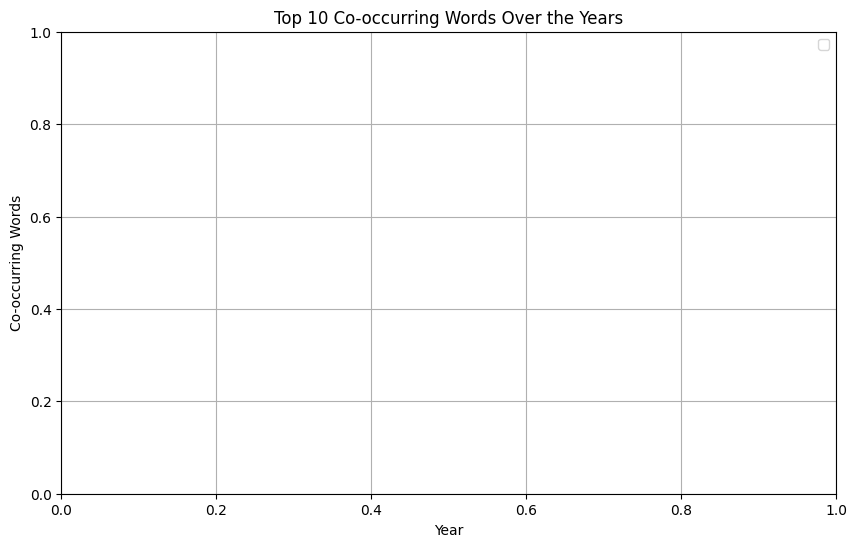

In [3]:
#Section 5
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('data/filtered_threads.csv')  # Replace with the path to your dataset

# Define your keyword
keyword = ["hyvinvointi", "vointi", "onnellisuus", "onni", "elämään tyytyväisyyttä","elävyyttä"]

# Function to find the co-occurring words within a 3-unit lexical distance
def find_cooccurring_words(text, keyword, window=3):
    words = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    cooccurring = []

    for i, word in enumerate(words):
        if word == keyword:
            start = max(0, i - window)
            end = min(len(words), i + window + 1)
            context = words[start:i] + words[i+1:end]
            cooccurring.extend(context)

    return cooccurring

# Create a dictionary to store co-occurring words for each year
cooccurring_words_by_year = {}

# Loop through the dataset and separate data for each year
for year in range(2001, 2004):
    data_for_year = df[df['datetime'].apply(lambda x: int(x[:4]) == year)]

    # Find co-occurring words for the current year
    cooccurring_words = []
    for text in data_for_year['thread_text']:
        if isinstance(text, str):
            cooccurring_words.extend(find_cooccurring_words(text, keyword))

    # Calculate the most frequent 10 co-occurring words for the year
    fdist = FreqDist(cooccurring_words)
    most_common = fdist.most_common(10)
    cooccurring_words_by_year[year] = most_common

# Plot the findings
plt.figure(figsize=(10, 6))
for i, year in enumerate(cooccurring_words_by_year.keys()):
    if cooccurring_words_by_year[year]:
        words, frequencies = zip(*cooccurring_words_by_year[year])
        plt.scatter([year] * 10, words, s=[freq * 10 for freq in frequencies], label=f'Year {year}')

plt.title('Top 10 Co-occurring Words Over the Years')
plt.xlabel('Year')
plt.ylabel('Co-occurring Words')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
#Section 6
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame to store co-occurring word frequencies
years = list(cooccurring_words_by_year.keys())
words = [item[0] for item in cooccurring_words_by_year[years[0]]]
data = []

for year in years:
    frequencies = [item[1] for item in cooccurring_words_by_year[year]]
    data.append(frequencies)

df = pd.DataFrame(data, columns=words, index=years)

# Generate a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Frequency'})
plt.title('Yearly Evolution of Top 10 Co-occurring Words')
plt.xlabel('Year')
plt.ylabel('Co-occurring Words')

# Save the heatmap as an image (or encode and save it to a database)
plt.savefig('cooccurring_words_heatmap.png')


ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x600 with 0 Axes>